# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import time
from datetime import timedelta
import cv2
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from tensorflow.contrib.layers import flatten

# TODO: fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Helper function for plotting images 
Function for plotting 9 images in a 3x3 grid 

In [3]:
img_size = 32
img_size_flat = img_size *img_size*3
img_shape = (img_size, img_size)
num_classes = 43

In [4]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    #create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        #plot image
        ax.imshow(images[i], cmap='binary')
        
        # show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        # remove ticks from the plot 
        ax.set_xticks([])
        ax.set_yticks([])
        

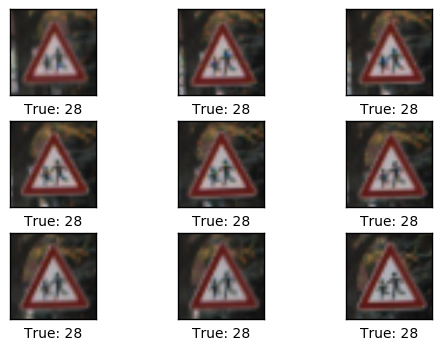

In [5]:
images = X_train[31000:31009]
cls_true = y_train[31000:31009]
plot_images(images = images, cls_true = cls_true)

class: 28


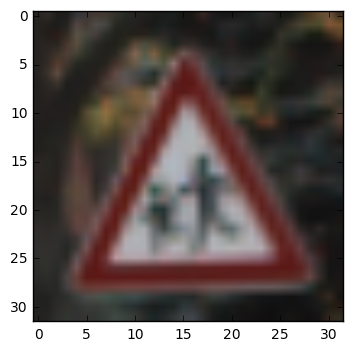

In [6]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
img_index = 31009
example_img = X_train[img_index]
plt.imshow(example_img)
print("class:" , y_train[img_index])

In [7]:
X_train[0].shape

(32, 32, 3)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

#### Preprocessing the dataset

Preprocessing the train, validation and test sets 
The folowing process uses the above function on the jittered data set (1.2 million images), the validation set (which I am making the same as the original X_train), and the test set (the original X_test).

The transform_image function The function tilts and warps the image within a random range. The function is called a number of times per image (right now my computer can only handle up to 40x per image -- to create a training set of 1.25 million images).

In [8]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### attribution: This is a function contributed on the forums, by Yivek Yadav

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
#     rows,cols,ch = img.shape 
    rows, cols = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

In [9]:
def pre_process_image(image):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (32,32),interpolation = cv2.INTER_CUBIC)
    
#     Min-Max scaling for greyscale image data
    Xmin = np.min(image)
    Xmax = np.max(image)
    a = -0.5
    b = 0.5
    
    image = a + ((image - Xmin) * (b-a)) / (Xmax-Xmin)

    return image

#### Preprocessing the images

The pre_process_image function takes the original image and converts it to grayscale, resizes it to 32x32, and then normalizes each grayscale pixel between 0.1 and 0.9. 

The flow of it was: 
1. convert to grayscale 
2. normalize
3. jitter to create a large training set
4. flatten


In [10]:
# preprocessing the original data - -converting to 1. grayscale and 2. normalizing

# the top two look similar, but I take the top one and jitter it later

# attribution - I think these functions are in the same format as an example I saw  on the forums, probably Yivek Yadav

image_GS_train = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))], dtype = np.float32)
image_GS_validation = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))], dtype = np.float32)
image_GS_test = np.array([pre_process_image(X_test[i]) for i in range(len(X_test))], dtype = np.float32)

print(len(image_GS_train))
print(len(image_GS_validation))
print(len(image_GS_test))
print((image_GS_train[0].shape))

39209
39209
12630
(32, 32)


## Augmenting the data with 3 million more images

In [11]:
# 3. creating 2 million images (around the best i could get my computer to do)

start_time = time.time()

jittered_images = []
jittered_labels = []

for i in range(len(image_GS_train)):
    for j in range(1):
        img = transform_image(image_GS_train[i],20,10,5)
        jittered_images.append(img)
        jittered_labels.append(y_train[i])

jittered_images = np.asarray(jittered_images)

end_time = time.time()
compute_time = end_time - start_time

print("compute time: " , str(timedelta(seconds = int(round(compute_time)))))
print("Length of the new jittered dataset: " , len(jittered_images))

compute time:  0:00:03
Length of the new jittered dataset:  39209


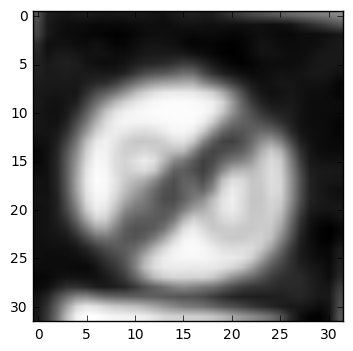

In [12]:
plt.imshow(jittered_images[10000], cmap='Greys_r')

In [13]:
# 4. Flattening the image data 
img_size_flat = 32*32

image_flat_train = jittered_images.reshape((-1,img_size_flat))
image_flat_validation = image_GS_validation.reshape((-1,img_size_flat))
image_flat_test  = image_GS_test.reshape((-1,img_size_flat))

print(len(image_flat_train))
print(len(image_flat_validation))
print(len(image_flat_test))
print((image_flat_train[0].shape))

39209
39209
12630
(1024,)


#### One-Hot encoding the labels

In [14]:
y_train_encoded = np.eye(43)[jittered_labels]
y_validation_encoded = np.eye(43)[y_train]
y_test_encoded = np.eye(43)[y_test]

print(len(y_train_encoded))
print(len(y_validation_encoded))
print(len(y_test_encoded))

39209
39209
12630


#### New Dataset facts 
The resultant datasets for the model are now: 


In [15]:
n_train = len(y_train_encoded)
n_validation = len(y_train)
n_test = len(y_test)
image_shape  = np.shape(X_train[1])
n_classes = len(np.unique(y_train))

img_size_flat = image_shape[0] * image_shape[1]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print("Image Size Flat =", img_size_flat)

Number of training examples = 39209
Number of validation examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Image Size Flat = 1024


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I generated additional data from the original dataset, using the transform image above. Then I used that much larger data set as the training set. 

Then I set the original training set of 31k images as my validation set. And the original test set of 12k images remained the test set. 

The hope was that the additional data would give a better testing accuracy. 

## Architecture

### Some functions for creating layers (*Note these layer and weight creating functions came from trying to follow the MNIST tutorial from here: https://www.youtube.com/watch?v=HMcx-zY8JSg: 

In [16]:
### Define your architecture here.
### Feel free to use as many code cells as needed.



In [17]:
# function for batching the data through the tensorflow model 

def random_batch():
    # Number of images in the training-set.
    num_images = len(image_flat_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
#     features_batch = image_flat_train[idx, :]
#     labels_batch = y_train_encoded[idx, :]
    
    features_batch = image_flat_validation[idx, :]
    labels_batch = y_validation_encoded[idx, :]
    return features_batch, labels_batch

### Placeholder variables and hyper parameters

### Tensorflow Model

In [18]:
img_size = 32
num_channels = 1
num_classes = 43
learning_rate = 1e-3
batch_size = 9
keep_prob = 0.9

beta = 0

x = tf.placeholder(tf.float32, [None, img_size_flat])
y = tf.placeholder(tf.float32, [None, n_classes])

# sets up a place for the non one-hot classes to go
y_true_cls = tf.placeholder(tf.int64, [None])

# this is putting the images back into the 4 dimensional format for the convo layers
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
input = x_image


# convolutinal layer 1 -- without the helper function
filter_size1 = 5       # Convolution filters are 5 x 5  pixels.
num_filters1 = 6       

shape = [filter_size1, filter_size1, num_channels, num_filters1]

weights1 = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
biases1 = tf.Variable(tf.constant(0.05, shape=[num_filters1]))

layer_conv1 = tf.nn.conv2d(input = input, filter=weights1, strides=[1, 1, 1, 1], padding='VALID') + biases1

# activation
layer_conv1 = tf.nn.relu(layer_conv1)

# max pool 16x16x16
layer_conv1 = tf.nn.max_pool(value=layer_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='VALID')

# convolutinal layer 2-- without the helper function
filter_size2 = 5       # Convolution filters are 5 x 5 pixels.
num_filters2 = 16        

input_layer_depth = 6

shape = [filter_size2, filter_size2, input_layer_depth , num_filters2]

weights2 = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
biases2 = tf.Variable(tf.constant(0.05, shape=[num_filters2]))

layer_conv2 = tf.nn.conv2d(input = layer_conv1, filter=weights2, strides=[1, 1, 1, 1], padding='VALID') + biases2

# activation
layer_conv2 = tf.nn.relu(layer_conv2)

# max pool 
layer_conv2 = tf.nn.max_pool(value=layer_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='VALID')
    



# flatten Layer (this makes it suitable ( a large matrix of the shape [num_pics,num_features]  numfor input into a FC layer)
fc1 = flatten(layer_conv2)

# fully connected layer 1
fc1_shape = (fc1.get_shape().as_list()[-1], 120)
fc1_size = 120

weights_fc1 = tf.Variable(tf.truncated_normal(shape=(fc1_shape)))
biases_fc1 = tf.Variable(tf.constant(0.05, shape=[fc1_size]))
                  
fc1 = tf.matmul(fc1, weights_fc1) + biases_fc1
fc1 = tf.nn.relu(fc1)

# fully connected layer 2
fc2_size = 43

weights_fc2 = tf.Variable(tf.truncated_normal(shape=(120,43)))
biases_fc2 = tf.Variable(tf.constant(0.05, shape=[fc2_size]))
                      
fc2 = tf.matmul(fc1, weights_fc2) + biases_fc2

# layer_out = tf.nn.dropout(layer_out, keep_prob)

y_pred = tf.nn.softmax(fc2)

y_pred_cls = tf.argmax(y_pred, dimension = 1)

# the cost function with L2 norm 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fc2, y)) + \
                                        beta*tf.nn.l2_loss(weights1) + \
                                        beta*tf.nn.l2_loss(biases1) + \
                                        beta*tf.nn.l2_loss(weights2) + \
                                        beta*tf.nn.l2_loss(biases2) + \
                                        beta*tf.nn.l2_loss(weights_fc1) + \
                                        beta*tf.nn.l2_loss(biases_fc1) + \
                                        beta*tf.nn.l2_loss(weights_fc2) + \
                                        beta*tf.nn.l2_loss(biases_fc2)

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)


correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [19]:
### Train your model here.
### Feel free to use as many code cells as needed.

def optimize(n_iterations):
    for iteration in range(n_iterations):
        features_batch, labels_true_batch = random_batch()
        feed_dict_batch = {x: features_batch, y: labels_true_batch}
        sess.run(optimizer, feed_dict = feed_dict_batch)


In [20]:
start_time = time.time()

sess = tf.Session()
sess.run(tf.initialize_all_variables())

iter = 10000

optimize(iter)

end_time = time.time()
compute_time = end_time - start_time

print("compute time: " , str(timedelta(seconds = int(round(compute_time)))))


compute time:  0:00:47


### Getting accuracy on the test set 

In [21]:

# feed_dict_test = {x: image_flat_test,
#                   y: y_test_encoded,
#                   y_true_cls:y_test}

feed_dict_test = {x: image_flat_validation,
                  y: y_validation_encoded,
                  y_true_cls:y_train}

acc = sess.run(accuracy,feed_dict=feed_dict_test)
print("Accuracy of the model on the validation set: " + str(acc))

Accuracy of the model on the validation set: 0.927109


## Test set accuracy

In [22]:

feed_dict_test = {x: image_flat_test,
                  y: y_test_encoded,
                  y_true_cls:y_test}

# feed_dict_test = {x: image_flat_validation,
#                   y: y_validation_encoded,
#                   y_true_cls:y_train}

acc = sess.run(accuracy,feed_dict=feed_dict_test)
print("Accuracy of the model on the test set: " + str(acc))

Accuracy of the model on the test set: 0.855107


In [23]:
# logging the output for future posterity

log_file = "log.txt"
special_note = "imgnormalization & changed filters to 3x3px & not L2norm & dropout & 3Conv-pool-2FC. uses an augmented dataset (80x), post-submission-model"
with open(log_file, "a") as myfile:
    myfile.write("\n"+str(iter)+","+str(learning_rate)+
                 ","+str(batch_size)+
                 ","+str(keep_prob)+
                 ","+ str(timedelta(seconds = int(round(compute_time))))+
                 ","+str(round(acc,2)) +
                 ","+special_note)


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The model was trained using the AdamOptimizer. The batch size I though twas the most efficient was around 100, and the number of iterations was 100k.  

The learning rate (learned by overfitting the tiny 9 image data set) was kept at 1e-3, and the "keep probability" -- the probablitly parameter for the dropout piece was maintained at 90%. 


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

The approach that worked best fror me was to first develop the model and practice over fitting a small subset (9 images) of the data. This process was quick and could generate a nice plot that represented the cost decreasing and the accuracy increasing. 

The benefit was that I could study the effects of some of the hyper parameters on the performance of the model, and adjust in a quickly iterative process. The parameters I delt with here were mainly the learning rate, regularization parameter and dropout percentage. 

Once I was satisfied with the basic architecture, I implemented the full dataset, and then the augmented data set. With this larger set of data the main pieces I worked with were the batch size and the number of iteratons. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [24]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### this is a plotting function originally created by Yivek Yadav

def plot_images(images, cls_true= None, cls_pred=None):
#     assert len(images) == len(cls_true) == 9
    
    #create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        #plot image
        ax.imshow(images[i].reshape(32,32),  cmap='Greys_r')
        
        # show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        # remove ticks from the plot 
        ax.set_xticks([])
        ax.set_yticks([])

In [25]:
import os, glob

new_signs= list()

path = "/home/deep_cat/traffic-signs-tensorflow/new_test_images"
test = os.path.join(path, '*.jpg')
print(test)


for infile in glob.glob(os.path.join(path, '*.jpg')):
    print(infile)
    img = cv2.imread(infile)
    arr1 = np.array(img)
    resize_img = cv2.resize(arr1, (32,32))
    new_signs.append(resize_img)
print(np.shape(new_signs))

/home/deep_cat/traffic-signs-tensorflow/new_test_images/*.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/6.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/9.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/7.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/2.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/4.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/1.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/5.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/3.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/8.jpg
(9, 32, 32, 3)


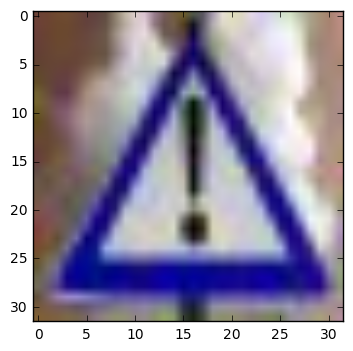

In [26]:
plt.imshow(new_signs[8])

In [27]:

images_gray_norm = np.array([pre_process_image(new_signs[i]) for i in range(len(new_signs))], dtype = np.float32)
images_flat= images_gray_norm.reshape((-1,img_size_flat))

In [28]:
y_new_signs = [21,9,23,28,11,1,1,14,18]
len(y_new_signs)
y_new_signs_encoded = np.eye(43)[y_new_signs]


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I chose 9 images from google image search and preprocessed them in the same manner as for the images above. Since the images began as a different sizes, the process for resizing and converting to grayscale warped them a bit. This may play into the  ability of the model to predict well, but the images are clear and should be decent data. 

The images are plotted below: 


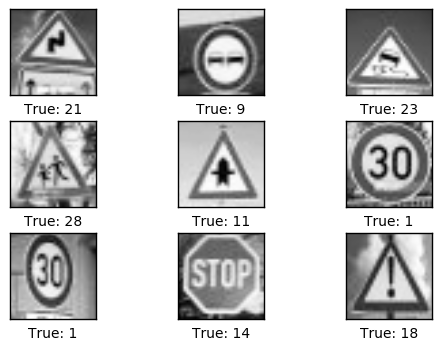

In [29]:
# images = new_signs_flat[0:9]
images = images_flat
cls_true = y_new_signs[0:9]
plot_images(images = images, cls_true = cls_true, cls_pred = None)

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_

**Anwer:**

No, for some reason I could not get a result out using my own images. The model predicted 19 for each as can seen below, and it does so with high confidence as can be seen in the bar graph for example 6 (which should be super easy to classify. 

In [30]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

feed_dict = {x: images}

top5 = tf.nn.top_k(y_pred, 5)

classification = sess.run(y_pred, feed_dict)

top5pred= sess.run(top5, feed_dict)
cls_pred = np.argmax(classification, axis=1)
print(cls_pred)


[17  9 23 28 11  2 31 14 18]


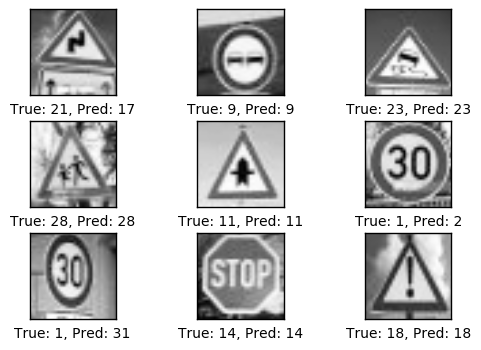

In [31]:
plot_images(images = images, cls_true = cls_true, cls_pred = cls_pred)

In [32]:
# this seems to work also , but gets the indices
classification[0]
classification[0].argsort()[-5:][::-1]


array([17, 31, 40, 14, 12])

In [33]:
top5pred.indices

array([[17, 31, 40, 14, 12],
       [ 9, 11, 30, 16, 20],
       [23, 19, 21, 11, 30],
       [28, 35,  3, 12, 11],
       [11, 21, 23, 30, 10],
       [ 2,  1,  3,  5,  6],
       [31, 16,  9,  3, 12],
       [14,  1, 37,  3, 25],
       [18, 26, 11, 27, 37]], dtype=int32)

In [34]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

top5 = tf.nn.top_k(y_pred, 5)
print(top5)

TopKV2(values=<tf.Tensor 'TopKV2_1:0' shape=(?, 5) dtype=float32>, indices=<tf.Tensor 'TopKV2_1:1' shape=(?, 5) dtype=int32>)


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

The top 5 probabilites for each of the images are below. The bar graph for the first image is relativly uncertain, but the rest show probabilities for the classification above 85%.

In [35]:
top5pred.values

array([[  9.47951734e-01,   5.04593737e-02,   6.62664184e-04,
          4.30942571e-04,   3.45176144e-04],
       [  8.36677074e-01,   1.45837337e-01,   9.39191692e-03,
          6.53094705e-03,   1.13793160e-03],
       [  9.84585226e-01,   1.52833164e-02,   1.23081598e-04,
          7.99455302e-06,   3.49657256e-07],
       [  9.88702536e-01,   5.12947980e-03,   2.90865009e-03,
          2.15814612e-03,   4.03344573e-04],
       [  9.99962211e-01,   3.66645254e-05,   4.40517141e-07,
          3.52390174e-07,   2.37456319e-07],
       [  9.19281960e-01,   8.06112811e-02,   7.04465565e-05,
          3.36997509e-05,   1.18180492e-06],
       [  3.98319244e-01,   1.97731435e-01,   1.31287560e-01,
          9.57230553e-02,   7.93377310e-02],
       [  7.21335530e-01,   9.73316655e-02,   9.37575325e-02,
          2.38869954e-02,   1.21803572e-02],
       [  9.96748686e-01,   3.25067667e-03,   4.67157719e-07,
          1.76774805e-07,   2.36869546e-09]], dtype=float32)

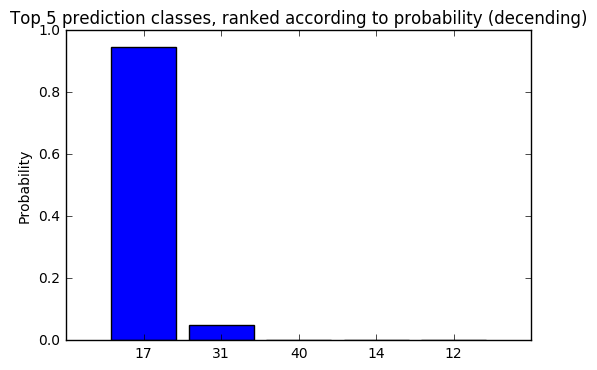

In [36]:
y = top5pred.values[0]
x = top5pred.indices[0]
y_pos = np.arange(len(top5pred.indices[0]))


width = 1/1.2
plt.bar(y_pos, y, width, color="blue", align = 'center')
plt.xticks(y_pos, x)
plt.ylabel('Probability')
plt.title('Top 5 prediction classes, ranked according to probability (decending)')



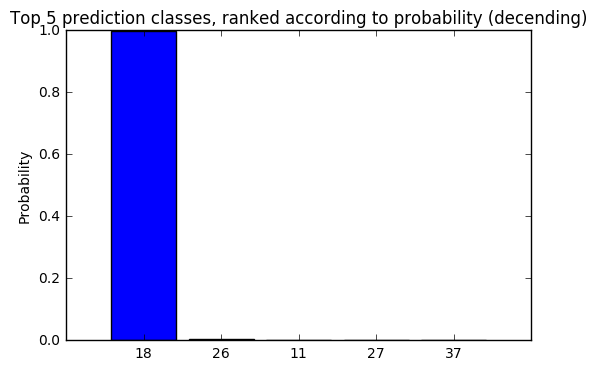

In [37]:
y = top5pred.values[8]
x = top5pred.indices[8]
y_pos = np.arange(len(top5pred.indices[0]))


width = 1/1.2
plt.bar(y_pos, y, width, color="blue", align = 'center')
plt.xticks(y_pos, x)
plt.ylabel('Probability')
plt.title('Top 5 prediction classes, ranked according to probability (decending)')

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**
I did not build anything special for this. I created an array of new images and then feed it into the session via the feed_dict. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [38]:
from twilio.rest import TwilioRestClient


with open('/home/deep_cat/twilio/sid.txt', 'r') as myfile:
    account_sid=myfile.read().replace('\n', '')
    
with open('/home/deep_cat/twilio/token.txt', 'r') as myfile:
    auth_token=myfile.read().replace('\n', '')
    
client = TwilioRestClient(account_sid, auth_token)

message = client.messages.create(body="Model Complete. accuracy: " + str(round(acc,2)) + "\nCompute time: "+ str(timedelta(seconds = int(round(compute_time)))),
    to="+14024807291",    # Replace with your phone number
    from_="+14028582009") # Replace with your Twilio number

print(message.sid)  

SMf346c7b6f45f41ec9b478b4e5ca2937d
